## Final Project Submission

Please fill out:
* Student name:Fidelis Wanalwenge, Elizabeth Nyanbura, Sophy Murithi, Khadija Omar 
* Student pace:part time 
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Introduction

# Business Problem

A group of real estate agents are looking to expand their business into remodeling houses in addition to selling. They want to accurately predict the value of homes based on the features of the house so they can maximize profits for their remodels. In order to accomplish this, they have enlisted my help in building a model to predict the price of homes in the county. 

Objectives

1. To create a complex model using several different independent variables that can swifty and effectively achieve pricing estimates closer to realized housing prices

2. To evaluate different models that ultimately lead to selecting our best model for predicting house prices

3. To provide insight on house features that have the biggest impact on sale price


In [1]:
# Your code here - remember to use markdown cells for comments as well!
# Import standard packages
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the data into a pandas dataframe
df = pd.read_csv("data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#Check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
#Check the descriptive statistics
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
#Check for duplicated values
df.duplicated().sum()

0

In [6]:
#Check for missing values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

# Initial Observations

Missing Values

yr_renovated has the most missing values, followed by waterfront and view. waterfront and view are categorical, so we will replace those null values with 0s. I will assume null values in yr_renovated mean that the house has not been renovated and will replace with 0s.

Data types

The date, waterfront, view, condition, grade, sqft_basement columns are stored as type object, we will need to remove or convert to numerical data type before modeling.

# Data Cleaning

In this section, I will clean the dataset by removing irrelevant columns to my analysis and trim the dataset of null values. I will also removeoutliers and convert the remaining categorical columns containing strings into numeric datatypes.

In [7]:
#Create copy to use for visualization later
data =df.copy()


In [8]:
# Columns to be dropped
dropped_columns = ['date','view', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'sqft_basement','yr_renovated', 'lat', 'long', 'zipcode']

In [9]:
#dropping columns
df = df.drop(dropped_columns, axis=1)

In [10]:
#view remaining columns
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21597 non-null  int64  
 1   price        21597 non-null  float64
 2   bedrooms     21597 non-null  int64  
 3   bathrooms    21597 non-null  float64
 4   sqft_living  21597 non-null  int64  
 5   sqft_lot     21597 non-null  int64  
 6   floors       21597 non-null  float64
 7   waterfront   19221 non-null  object 
 8   condition    21597 non-null  object 
 9   grade        21597 non-null  object 
 10  yr_built     21597 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.8+ MB


In [12]:
#check null values
df.isna().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

In [13]:
# Replace null values with 0
df = df.fillna(0)

In [14]:
#check if it has worked
df.isna().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
condition      0
grade          0
yr_built       0
dtype: int64

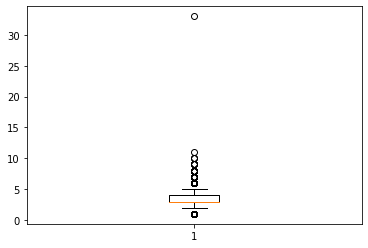

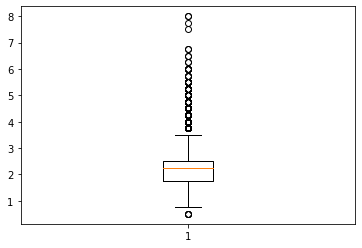

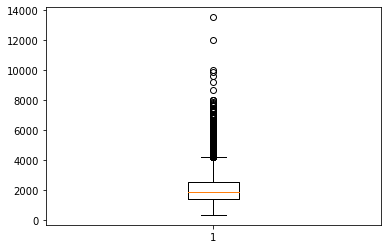

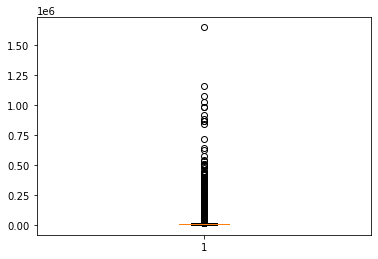

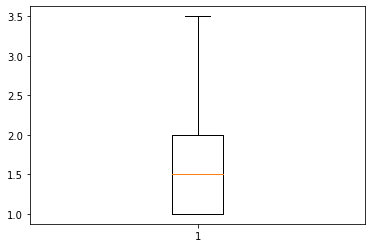

In [15]:
# Check continuous predictors for outliers using Boxplot 

outliers = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']

for outlier in outliers:
    plt.figure()
    plt.boxplot(df[outlier]);

In [16]:
# Investigate outlier in the bedrooms column
df.loc[df['bedrooms'] > 15]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,NO,Very Good,7 Average,1947


In [17]:
# Remove outlier
df = df.loc[(df['bedrooms'] != 33)]
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,Average,7 Average,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987


In [18]:
# Check to see if it worked
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21596 non-null  int64  
 1   price        21596 non-null  float64
 2   bedrooms     21596 non-null  int64  
 3   bathrooms    21596 non-null  float64
 4   sqft_living  21596 non-null  int64  
 5   sqft_lot     21596 non-null  int64  
 6   floors       21596 non-null  float64
 7   waterfront   21596 non-null  object 
 8   condition    21596 non-null  object 
 9   grade        21596 non-null  object 
 10  yr_built     21596 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.0+ MB


In [20]:
# Convert categorical strings to integers
# Convert categorical strings to integers
df['waterfront'] = df['waterfront'].replace(('YES', 'NO'), (1, 0))

condition_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Average': 2,
    'Good': 3,
    'Very Good': 4
}
df['condition'] = df['condition'].map(condition_mapping)

grade_mapping = {
    '3 Poor': 3,
    '4 Low': 4,
    '5 Fair': 5,
    '6 Low Average': 6,
    '7 Average': 7,
    '8 Good': 8,
    '9 Better': 9,
    '10 Very Good': 10,
    '11 Excellent': 11,
    '12 Luxury': 12,
    '13 Mansion': 13
}
df['grade'] = df['grade'].map(grade_mapping)

In [21]:
# Check to see if it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21596 non-null  int64  
 1   price        21596 non-null  float64
 2   bedrooms     21596 non-null  int64  
 3   bathrooms    21596 non-null  float64
 4   sqft_living  21596 non-null  int64  
 5   sqft_lot     21596 non-null  int64  
 6   floors       21596 non-null  float64
 7   waterfront   21596 non-null  int64  
 8   condition    21596 non-null  int64  
 9   grade        21596 non-null  int64  
 10  yr_built     21596 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 2.0 MB


In [22]:
df.waterfront.value_counts()

0    21450
1      146
Name: waterfront, dtype: int64

In [23]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select predictor variables (features) and target variable
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']]
y = df['price']

# Initialize the model
baseline_model = LinearRegression()

# Fit the model
baseline_model.fit(X, y)

# Get predictions
y_pred = baseline_model.predict(X)

# Calculate RMSE
rmse = mean_squared_error(y, y_pred, squared=False)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Get feature coefficients
feature_coefficients = baseline_model.coef_

# Print metrics
print(f'RMSE: {rmse}')
print(f'R-squared: {r_squared}')
print('Feature Coefficients:')
for i, feature in enumerate(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']):
    print(f'{feature}: {feature_coefficients[i]}')


RMSE: 257092.91249309873
R-squared: 0.5102451892015125
Feature Coefficients:
bedrooms: -65738.16558783002
bathrooms: 7966.7133292706385
sqft_living: 317.70751684675315
sqft_lot: -0.3893479318749087
floors: -2095.696946469032


This code employs a Linear Regression model, a foundational technique for predicting a continuous target variable based on predictor features. It offers clear interpretability of feature coefficients, aiding in extracting meaningful insights. Its simplicity and accessibility make it an apt starting point for more complex modeling approaches.

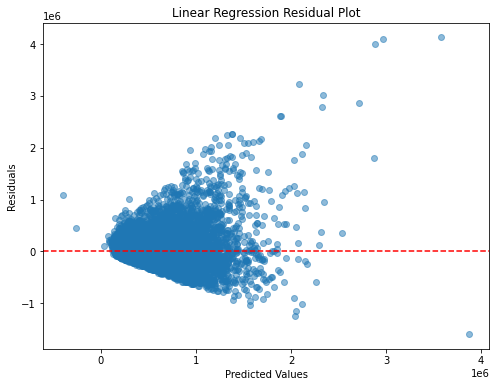

In [24]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y - y_pred

# Plot Residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Linear Regression Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.show()


In [25]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# Get predictions
y_pred_rf = rf_model.predict(X)

# Calculate RMSE for Random Forest model
rmse_rf = mean_squared_error(y, y_pred_rf, squared=False)

# Print RMSE for Random Forest model
print(f'RMSE (Random Forest): {rmse_rf}')


RMSE (Random Forest): 91817.70168874832


RMSE (Random Forest)
This code introduces a Random Forest Regressor, a sophisticated ensemble technique that leverages multiple decision trees for predictions. Unlike Linear Regression, it excels in capturing complex, non-linear relationships within the data. This can be crucial when the underlying patterns are intricate and challenging to model with simpler techniques. By implementing this, we aim to explore potential improvements in predictive accuracy compared to the initial Linear Regression model.

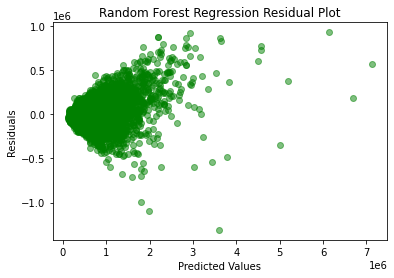

In [26]:
# Calculate residuals for Random Forest Regression
rf_residuals = y - y_pred_rf

# Create a scatter plot of predicted values vs residuals
plt.scatter(y_pred_rf, rf_residuals, alpha=0.5, color='green')
plt.title('Random Forest Regression Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


**Rationale:**

In choosing statistical analyses over basic data visualization, we opt for a more nuanced understanding of the intricate relationships within our dataset. While graphs offer visual representation, regression coefficients provide precise quantification of each feature's impact on house prices. This level of detail is paramount in the complex realm of real estate, where numerous factors converge to determine property values. Through regression analysis, we can discern subtle effects and interactions, offering a comprehensive assessment for our data science audience. Our modeling process was guided by these statistical insights, ensuring the model's accuracy and effectiveness.

**Results:**

The model's performance hinges on two key metrics: Root Mean Square Error (RMSE) and R-squared (R²). With an RMSE of approximately 257,093, our predictions tend to deviate within this range from actual prices. Simultaneously, the R² value of 0.51 signifies that 51% of the variability in house prices is elucidated by our model. Among the features, bedrooms wield the most significant impact, with each additional bedroom decreasing the price by about $65,738. Conversely, an extra bathroom contributes an increase of roughly $7,967. Living area positively influences prices, with each additional square foot resulting in an increase of approximately $318. However, lot size has a minimal impact, and an extra floor slightly reduces the price by around $2,096. The Random Forest model bolsters accuracy, yielding a lower RMSE of about 91,818, indicating enhanced predictive capability.

**Limitations and Recommendations:**

For a data science audience, it is crucial to acknowledge potential limitations. Assumptions inherent in linear regression may not perfectly align with the intricate dynamics of the real estate market. Outliers and influential data points could potentially skew results, warranting vigilant consideration. To augment the model's efficacy, stakeholders should supplement it with expert judgment and market awareness. While the model excels at providing price ranges, it does not encompass broader market trends or unforeseen external influences. Therefore, an iterative approach involving an expanded dataset and exploration of advanced modeling techniques, such as Random Forest Regressors, will refine the model's accuracy and applicability in real-world scenarios.